In [192]:
import json
import pandas as pd
import re 
import matplotlib.pyplot as plt
import random
from textblob import TextBlob

In [193]:
def get_color(r, g, b):
        """ Retourne une couleur à partir de ses composantes r, g, b entre 0 et 255"""
        return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def cool_alé():
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        couleur = get_color(r,g,b)
        return couleur



In [194]:
class Tweet:
    nbr_de_tweets_par_user = {}
    user_mentionnnees = {}
    hashtags = {}
    sentiments = {}
    topics = {}

    def __init__(self,data):
        self.tweet = data.get("id")
        self.utilisateur = data.get("author_id")
        self.texte = data.get("text")
        self.hashtags = self.extraire_hashtags(data)
        self.mentions = self.extract_mentions(data)
        self.sentiment = self.extract_sentiment(self.texte)
        self.topic = self.extract_topic(data)
        self.entities = data.get("entities",{})

        Tweet.nbr_de_tweets_par_user[self.utilisateur]= Tweet.nbr_de_tweets_par_user.get(self.utilisateur,0) + 1
        
        for hashtag in self.hashtags:
            Tweet.hashtags[hashtag] = Tweet.hashtags.get(hashtag,0) + 1

        for mention in self.mentions:
            Tweet.user_mentionnnees[mention] = Tweet.user_mentionnnees.get(mention, 0) + 1

        Tweet.sentiments[self.tweet] = self.sentiment

        Tweet.topics[self.tweet] = self.topic
        
    
    def extraire_hashtags(self,data):
        entities = data.get('entities', {})
        hashtags = entities.get('hashtags',[])
        return [tag['tag'] for tag in hashtags]
    
    def extract_mentions(self,data):
        entities = data.get('entities',{})
        mentions = entities.get("mentions",[])
        return [username['username'] for username in mentions]
    
    def extract_sentiment(self,texte):
        text_blob = TextBlob(texte)
        if text_blob.sentiment.polarity > 0:
            sentiment = "positif"
        if text_blob.sentiment.polarity < 0:
            sentiment = "negatif"
        if text_blob.sentiment.polarity == 0:
            sentiment = "neutre"
        return sentiment
    
    def extract_topic(self, data):
        annotations = data.get("context_annotations", [])
    
        domain_names = []
        
        for annotation in annotations:

            domain_names.append(annotation["domain"]["name"])
        

        unique_domain = list(set(domain_names))
        return unique_domain




def TopK_hashtags(k):
    """Fonction qui donne le Top K hashtags"""
    if k <= len(Tweet.hashtags):
        hashtags_tries = sorted(Tweet.hashtags.items(), key=lambda x: x[1], reverse=True) 
        # On prend les hashtags et leur nombre d'apparitions, et on le trie en fct du nbre d'apparition d'ou le x[1] , decroissant ==> reverse = True
        top_k_hashtags = hashtags_tries[:k]
    else:
        print(f"Le top {k} de hashtags n'est pas possible car le nombre total de hashtags est {len(Tweet.hashtags)}")
        k = int(input("Selectionner un le k"))
        return TopK_hashtags(k)
    return top_k_hashtags

  

def TopK_users(k):
    """Fonction qui donne le Top K utilisateurs ayant le plus publié"""
    if k <= len(Tweet.nbr_de_tweets_par_user):
        users_tries = sorted(Tweet.nbr_de_tweets_par_user.items(), key=lambda x: x[1], reverse=True)
        top_k_users = users_tries[:k]
        return top_k_users
    else:
        print(f"Le top {k} utilisateurs ayant le plus publié n'est pas possible car le nombre total d'utilisateurs est {len(Tweet.nbr_de_tweets_par_user)}")
        k = int(input("Selectionner un le k"))
        return TopK_users(k)
    

def TopK_mentions(k):
    """Fonction qui donne le Top K utilisateurs ayant le plus publié"""
    if k <= len(Tweet.user_mentionnnees):
        mentions_tries = sorted(Tweet.user_mentionnnees.items(), key=lambda x: x[1], reverse=True)
        top_k_mentions = mentions_tries[:k]
        return top_k_mentions
    else:
        print(f"Le top {k} utilisateurs ayant été le plus mentionné n'est pas possible car le nombre total d'utilisateurs ayant deja été mentionné est {len(Tweet.nbr_de_tweets_par_user)}")
        k = int(input("Selectionner un le k"))
        return TopK_users(k)
    

def TopK_topics(k):

    occurrences = {}


    for key, values in Tweet.topics.items():

        for value in values:

            value_key = tuple(value) if isinstance(value, list) else value

            occurrences[value_key] = occurrences.get(value_key, 0) + 1

    a = sorted(occurrences.items(),key = lambda x:x[1],reverse = True)
    list_k = dict(a[:k])

    return list_k

def tweet_json(nom_fichier):
    with open(nom_fichier,"r",encoding="utf-8") as fichier:
        donnees_tweets = json.load(fichier)
    return [Tweet(tweet) for tweet in donnees_tweets]

jeu_de_tweets = tweet_json("versailles_tweets_100.json")



def nbr_publications_user(user_id):
    if user_id in Tweet.nbr_de_tweets_par_user:

        return (f"L'utilisateur {user_id} a publié {Tweet.nbr_de_tweets_par_user[user_id]} publications")

    else:
        print(f"L'utilisateur {user_id} n'éxiste pas!")

def nbr_publications_hashtag(hasht):
    if hasht in Tweet.hashtags:
        return (f"Le hashtag {hasht} apparait dans {Tweet.hashtags[hasht]} publications")
    else:
        return (f"Le hashtag {hasht} n'éxiste pas!")

def nbr_publications_topics(topic):

    existe = False
    for tweet_id, topics in Tweet.topics.items():
        if topic in topics:
            existe = True

    if existe == True:
        count = sum(1 for topics_list in Tweet.topics.values() if topic in topics_list)  

        return (f"Le Topic {topic} existe dans {count} publications")

    else:
        print(f"Le topic {topic} n'éxiste pas!") 


def cleaning_zone_atterissage(source, destination):
    with open(source, "r", encoding="utf-8") as fichier_entree:
        donnees_tweets = json.load(fichier_entree)

    tweets_nettoyes = []

    for tweet in donnees_tweets:
        texte_tweet = tweet.get("text", "")
        texte_nettoye = re.sub(re.compile("[^\\w',:[ #@.,/*$+=:;]"), '', texte_tweet)
        tweet["text"] = texte_nettoye
        tweets_nettoyes.append(tweet)

    with open(destination, "w", encoding="utf-8") as fichier_sortie:
        json.dump(tweets_nettoyes, fichier_sortie, ensure_ascii=False, indent=2)    # Ecrire l'objet à la destination avec des éspaces (indent)/ ensure_ascii = False ==> les lettre avec accents laissé tel quel


def tweets_by_user(user_id, tweets):
    tweets_user = [tweet for tweet in tweets if tweet.utilisateur == user_id]
    return tweets_user

def display_tweets_user(user_id, tweets):
    tweets_de_utilisateur = tweets_by_user(user_id, tweets)
    if tweets_de_utilisateur:
        print(f"Tweets de l'utilisateur {user_id}:")
        for tweet in tweets_de_utilisateur:
            print(tweet.texte)
    else:
        print(f"Aucun tweet de l'utilisateur{user_id}")



def tweets_mentionned_a_user(user_id, tweets):
     tweets_mentionnant_utilisateur = [tweet for tweet in tweets if user_id in [mention["username"] for mention in tweet.entities.get("mentions", [])]]
     return tweets_mentionnant_utilisateur



def display_tweets_mentionned_user(user_id,tweets):
    tweets = tweets_mentionned_a_user(user_id,tweets)
    if tweets:
        print(f"Tweets mentionnnant {user_id}:")
        for tweet in tweets:
            print(tweet.texte)
    else:
        print(f"Aucun tweets trouve mentionnant {user_id}")



def user_per_hashtags(hashtag, tweets):
    users_mentioning_hashtag = set()
    
    for tweet in tweets:
        hashtags = [tag["tag"].lower() for tag in tweet.entities.get("hashtags", [])]
        if hashtag.lower() in hashtags:
            users_mentioning_hashtag.add(tweet.utilisateur)

    return list(users_mentioning_hashtag)

def display_user_per_hashtags(hashtag, tweets):
    utilisateurs_mentionnant_hash = user_per_hashtags(hashtag, tweets)
    if utilisateurs_mentionnant_hash:
        print(f"Utilisateurs mentionnant #{hashtag}:")
        for user_id in utilisateurs_mentionnant_hash:
            print(user_id)
    else:
        print(f"Aucun utilisateur mentionnant #{hashtag}")



def user_mentionned_per_user(user_id,tweets):
    mentioned_users = set()
    
    for tweet in tweets:

        if tweet.utilisateur == user_id:
            mentions = [mention["username"] for mention in tweet.entities.get("mentions",[])]
            mentioned_users.update(mentions)
    return mentioned_users
            
        

def display_users_mentionned_per_users(user_id, tweets):
    mentioned_users = user_mentionned_per_user(user_id, tweets)
    if mentioned_users:
        print(f"Utilisateurs mentionnes par {user_id}:")
        for mentioned_user_id in mentioned_users:
            print(mentioned_user_id)
    else:
        print(f"Aucun utilisateur mentionne par {user_id}")

def identification_user_id(tweet_imp,data):
    for tweet in data:
        if tweet_imp == tweet.tweet:
            user_id = tweet.utilisateur
        
    return (f"L'utilisateur qui a publié cette publication: {tweet_imp} est {user_id}")
        

def identification_sentiment_tweet(tweet_imp,data):
    for tweet in data:
        if tweet_imp == tweet.tweet:
            sentiment = tweet.sentiment

    return f"Le sentiment de la publication: {tweet_imp} est {sentiment}"


def indentification_topic_tweet(tweet_imp,data):
    for tweet in data:
        if tweet_imp == tweet.tweet:
            topic = tweet.topic
    return f"Le topic de la publication: {tweet_imp} est {topic}"

In [206]:
""" Nettoyage de données """

# Nettoyage du fichier texte --> zone d'
#print(cleaning_zone_atterissage("versailles_tweets_100.json", "zone_d'atterissage"))

""" Traitement de données """

#1 Identification de l’auteur de la publication
#print(identification_user_id("1421599163561742339",jeu_de_tweets))
#2 Extraction de la liste de hashtags de la publication
#print(Tweet.hashtags.keys())
#3 Extraction de la liste des utilisateurs mentionnés dans la publication 
#print(Tweet.user_mentionnnees.keys())
#4 Analyse de sentiment de la publication (le sentiment peut être positif ou bien négatif). 
#print(identification_sentiment_tweet("1421581383454052359",jeu_de_tweets))
#5 Identification du/des topics de la publication
#print(indentification_topic_tweet("1421599703116943360",jeu_de_tweets))

""" Analyse de données """

#1 Top K hashtags (k est un paramètre passé par l’utilisateur)
#print(TopK_hashtags(8))

#2 Top K utilisateurs 
#print(TopK_users(11))

#3 Top K utilisateurs mentionnées 
#print(TopK_mentions(15))

#4
#print(TopK_topics(2))

#5 Le nombre de publications par utilisateur
#print(nbr_publications_user("1339914264522461187"))

#6 Le nombre de publications par hashtag
#print(nbr_publications_hashtag("CIV"))

#7Le nombre de publications par topic
#print(nbr_publications_topics("Sports Event"))

#8 L'ensemble de tweets d’un utilisateur spécifique
#print(display_tweets_user("1339914264522461187",jeu_de_tweets))

#9 L’ensemble de tweets mentionnant un utilisateur spécifique
#print(display_tweets_mentionned_user("maxigr04del",jeu_de_tweets))

#10 Les utilisateurs mentionnant un hashtag spécifique
#print(display_user_per_hashtags("twitter225",jeu_de_tweets)) 

#11 Les utilisateurs mentionnés par un utilisateur spécifique
#print(display_users_mentionned_per_users("1339914264522461187",jeu_de_tweets))


Tweets mentionnnant maxigr04del:
@ericbailly24 @maxigr04del  mes tontons vous avez fait votre part , JO prochain on ira en demi final au moins. BRAVO à vous . #SupportriceMazo #domie #CIV
None


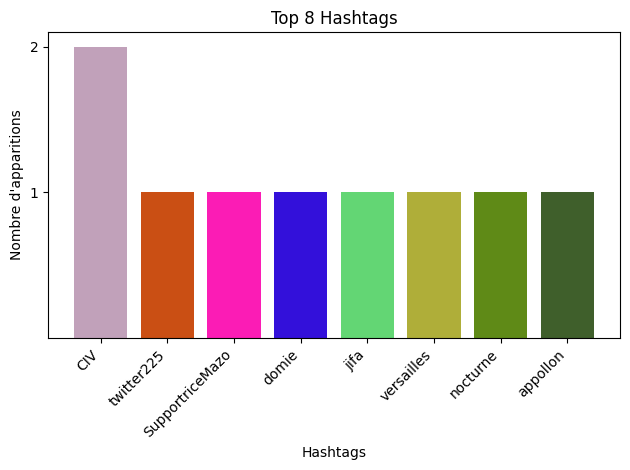

In [196]:
def plt_hashtags_histogram(hashtags, nbr_hashtags):
    
    couleurs = [cool_alé() for _ in range(len(hashtags))]
    plt.bar(hashtags, nbr_hashtags, color=couleurs[:len(hashtags)]) # Ce que l'on va mettre dans: abscisse : Nom / ordonnée: nbr_publi / les couleurs 
    plt.xlabel("Hashtags")   # Titre Abscisse
    plt.ylabel("Nombre d'apparitions")    # Titre ordonnée
    plt.title(f'Top {len(hashtags)} Hashtags')      # Titre
    plt.xticks(rotation=45, ha="right")     # Rotation des étiquettes de l'abscisse
    plt.yticks(range(int(min(nbr_de_hashtags)), int(max(nbr_de_hashtags))+1))  #echelle de l'ordonnée en entier    
    plt.tight_layout()      # Adapte en fct des données l'echelle
    plt.show()      # Montre le graph

top_hashtags = TopK_hashtags(8)

hashtags, nbr_de_hashtags = zip(*top_hashtags)

plt_hashtags_histogram(hashtags, nbr_de_hashtags)

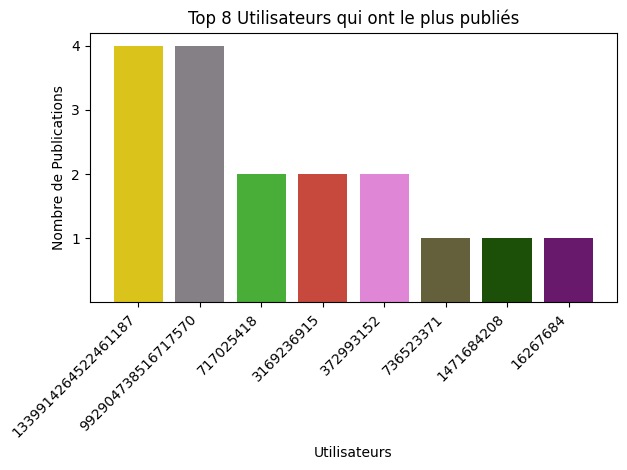

In [197]:
def plt_users_histogram(users, publications):

    couleurs = [cool_alé() for _ in range(len(hashtags))]
    plt.bar(users, publications, color=couleurs[:len(users)])   # Ce que l'on va mettre dans: abscisse : Nom / ordonnée: nbr_publi / les couleurs 
    plt.xlabel("Utilisateurs")      # Titre abscisse 
    plt.ylabel("Nombre de Publications")     # Titre ordonnée
    plt.title(f'Top {len(users)} Utilisateurs qui ont le plus publiés')   # Titre 
    plt.xticks(rotation=45, ha="right")  # Rotation des étiquettes de l'abscisse
    plt.yticks(range(int(min(nbr_publications)), int(max(nbr_publications))+1))  #echelle de l'ordonnée en entier
    plt.tight_layout()      # Adapte en fct des données l'echelle
    plt.show()      # Montre le graph

# On appel la fonction pour obtenir le top k utilisateurs
top_publi_utulisateurs = TopK_users(8)

# On extraie les utilisateurs et le nombre de publications
utilisateurs, nbr_publications = zip(*top_publi_utulisateurs)

plt_users_histogram(utilisateurs, nbr_publications)

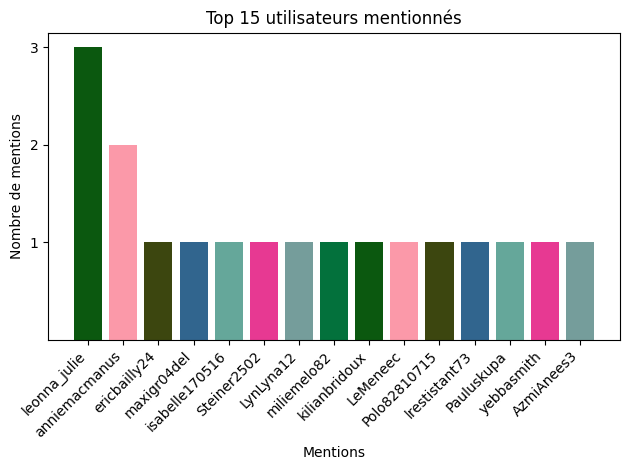

In [198]:
def plt_mentions_histogram(mentions, frequencies):
    couleurs = [cool_alé() for _ in range(len(hashtags))]

    plt.bar(mentions, frequencies, color=couleurs[:len(mentions)])
    plt.xlabel("Mentions")
    plt.ylabel("Nombre de mentions")
    plt.title(f'Top {len(mentions)} utilisateurs mentionnés')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(range(int(min(frequencies)), int(max(frequencies))+1))

    plt.tight_layout()
    plt.show()

top_mentions = TopK_mentions(15)

mentions, frequencies = zip(*top_mentions)

plt_mentions_histogram(mentions, frequencies)

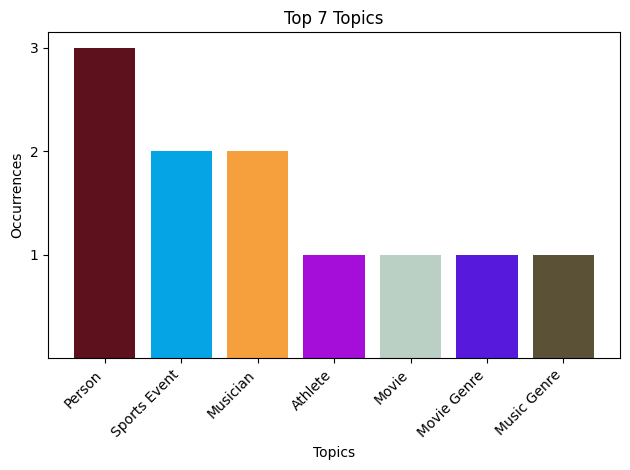

In [199]:
import matplotlib.pyplot as plt

def plt_topics_histogram(topics, frequencies):
    couleurs = [cool_alé() for _ in range(len(topics))] 

    plt.bar(topics, frequencies, color=couleurs[:len(topics)])
    plt.xlabel("Topics")
    plt.ylabel("Occurrences")
    plt.title(f'Top {len(topics)} Topics')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(range(int(min(frequencies)), int(max(frequencies)) + 1))

    plt.tight_layout()
    plt.show()

top_k_topics = TopK_topics(7)

topics, frequencies = zip(*top_k_topics.items())

plt_topics_histogram(topics, frequencies)
